Install dependencies

In [ ]:
!pip install gym

In [ ]:
!git clone https://github.com/JKCooper2/gym-bandits.git
!pip install /content/gym-bandits/.

Cloning into 'gym-bandits'...
remote: Enumerating objects: 73, done.
remote: Total 73 (delta 0), reused 0 (delta 0), pack-reused 73
Receiving objects: 100% (73/73), 14.67 KiB | 2.93 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Processing ./gym-bandits
  Preparing metadata (setup.py) ... done
  Created wheel for gym-bandits: filename=gym_bandits-0.0.2-py3-none-any.whl size=5176 sha256=d51a4f334d983b0869f2b69d24cee7aa6ef8b7599291c542eb35df63b25d20da
  Stored in directory: /root/.cache/pip/wheels/c3/08/26/864a6d1117e7bfa76123a5bde6db05037a94b056b2f6ee5f5c
Successfully built gym-bandits


In [ ]:
import gym
import gym_bandits
import numpy as np
import pandas as pd
import seaborn as sns

OpenAI Gym (https://github.com/openai/gym)

Gym is an open source Python library for developing and comparing reinforcement learning algorithms by providing a standard API to communicate between learning algorithms and environments, as well as a standard set of environments compliant with that API. Since its release, Gym's API has become the field standard for doing this.

Gym documentation website is at https://www.gymlibrary.dev/

Explore existing bandit environments with 2 arms

Source: https://github.com/JKCooper2/gym-bandits/blob/master/gym_bandits/bandit.py

*   BanditTwoArmedDeterministicFixed: Simplest case where one bandit always pays, and the other always doesn't
*   BanditTwoArmedHighLowFixed: Stochastic version with a large difference between which bandit pays out of two choices
*   BanditTwoArmedHighHighFixed: Stochastic version with a small difference between which bandit pays where both are good
*   BanditTwoArmedLowLowFixed(BanditEnv): Stochastic version with a small difference between which bandit pays where both are bad

```python
# p_dist:
#     A list of probabilities of the likelihood that a particular bandit will pay out
# r_dist:
#     A list of either rewards (if number) or means and standard deviations (if list)
#     of the payout that bandit has


class BanditTwoArmedDeterministicFixed(BanditEnv):
    """Simplest case where one bandit always pays, and the other always doesn't"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[1, 0], r_dist=[1, 1])


class BanditTwoArmedHighLowFixed(BanditEnv):
    """Stochastic version with a large difference between which bandit pays out of two choices"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.2], r_dist=[1, 1])


class BanditTwoArmedHighHighFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are good"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.9], r_dist=[1, 1])


class BanditTwoArmedLowLowFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are bad"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.1, 0.2], r_dist=[1, 1])

```



In [ ]:
env = gym.make('BanditTwoArmedDeterministicFixed-v0')
# env = gym.make('BanditTwoArmedHighLowFixed-v0')
# env = gym.make('BanditTwoArmedHighHighFixed-v0')
# env = gym.make('BanditTwoArmedLowLowFixed-v0')

n_arms = 2
n_episodes = 1000

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def execute(environment, n_ep, n_a, policy):

  rewards = np.zeros(shape=(n_ep, n_a))
  pulls = np.ones(n_a)

  environment.reset()
  env.seed(42)
  np.random.seed(42)

  for episode in range(n_ep):

      if policy == "greedy":
        action = greedy(rewards, pulls)
      elif policy == "e_greedy":
        action = e_greedy(rewards, pulls)
      elif policy == "random":
        action = random_policy()

      pulls[action] = pulls[action] + 1

      observation, reward, done, info = environment.step(action)  # execute new step

      rewards[episode, action] = reward # update rewards

  environment.close()

  print("Return: " + str(np.sum(np.sum(rewards,axis=0))))
  return rewards

In [ ]:
def random_policy():
  return np.random.choice(n_arms) # choose one arm at random

rewards = execute(env, n_episodes, n_arms, "random")

Return: 158.0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(

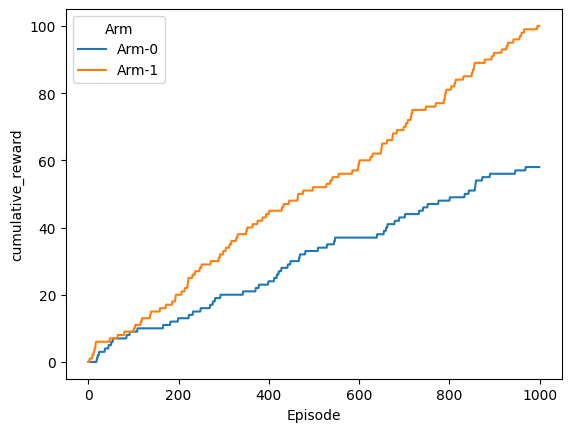

In [ ]:
def plot_cumulative_rewards(rew):
  bandits = ["Arm-" + str(i) for i in range(rew.shape[1])]

  rewards_df = pd.DataFrame(rew, columns=bandits)
  rewards_df["Episode"] = range(n_episodes)

  rewards_melted = pd.melt(rewards_df,
                          id_vars=["Episode"],
                          var_name="Arm",
                          value_vars=bandits,
                          value_name="reward")

  rewards_melted['cumulative_reward'] = rewards_melted.groupby('Arm')["reward"].transform('cumsum')

  sns.lineplot(data=rewards_melted, x='Episode', y='cumulative_reward', hue='Arm')

plot_cumulative_rewards(rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Return: 159.0


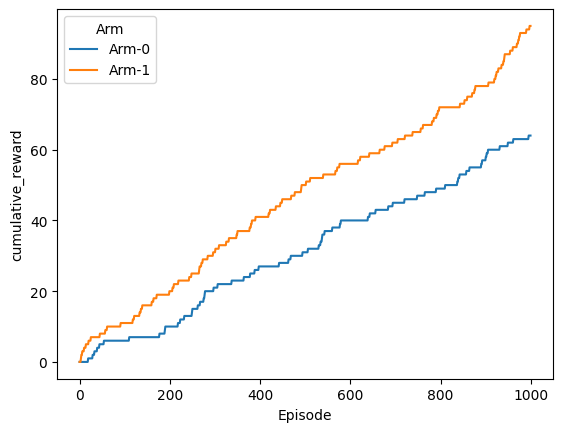

In [ ]:
def greedy(rew, pul):
  sample_average = np.sum(rew)/pul
  action = np.random.choice(np.where(sample_average == sample_average.max())[0])
  return action

rewards = execute(env, n_episodes, n_arms, "greedy")
plot_cumulative_rewards(rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Return: 206.0


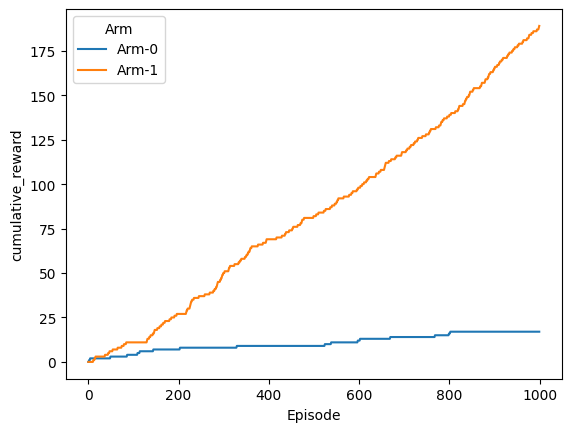

In [ ]:
def e_greedy(rew, pul):
  sample_average = np.sum(rew, axis=0)/pul
  epsilon = 0.3

  if np.random.rand() < epsilon:
    # print("Exploring...")
    action = np.random.choice(range(rew.shape[1]))

  else:
    # print("Exploiting...")
    action = np.argmax(sample_average)

  return action

rewards = execute(env, n_episodes, n_arms, "e_greedy")
plot_cumulative_rewards(rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
